In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
sp500 = yf.Ticker("^GSPC")

sp500 = sp500.history(period="max")

sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-24 00:00:00-04:00,5281.450195,5311.649902,5278.390137,5304.720215,3005510000,0.0,0.0
2024-05-28 00:00:00-04:00,5315.910156,5315.910156,5280.890137,5306.040039,3751540000,0.0,0.0
2024-05-29 00:00:00-04:00,5278.729980,5282.270020,5262.700195,5266.950195,3552750000,0.0,0.0


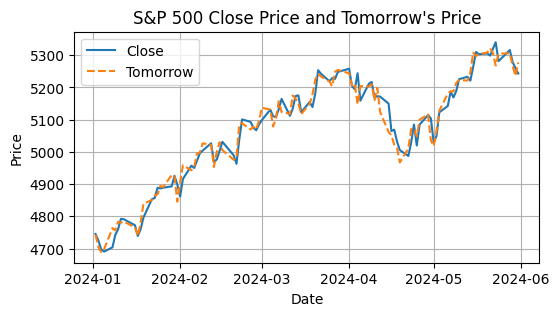

In [8]:
sp500 = sp500.drop(["Dividends","Stock Splits"], axis=1)
sp500 = sp500[sp500.index > pd.to_datetime('2024-01-01 00:00:00-05:00').tz_convert('America/New_York')]
sp500["Tomorrow"] = sp500["Close"].shift(-1)

plt.figure(figsize=(6, 3))
plt.plot(sp500.index, sp500["Open"], label='Close')
plt.plot(sp500.index, sp500["Close"], label='Tomorrow', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('S&P 500 Close Price and Tomorrow\'s Price')
plt.legend()
plt.grid(True)
plt.show()

### Creating a Taget ###
We create a 'target' variable which is a truth value, positive if the next day's 'Close' price will go up as compared to today. 

In [9]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2024-01-02 00:00:00-05:00,4745.200195,4754.330078,4722.669922,4742.830078,3743050000,4704.810059,0
2024-01-03 00:00:00-05:00,4725.069824,4729.290039,4699.709961,4704.810059,3950760000,4688.680176,0
2024-01-04 00:00:00-05:00,4697.419922,4726.779785,4687.529785,4688.680176,3715480000,4697.240234,1
2024-01-05 00:00:00-05:00,4690.569824,4721.490234,4682.109863,4697.240234,3844370000,4763.540039,1
2024-01-08 00:00:00-05:00,4703.700195,4764.540039,4699.819824,4763.540039,3742320000,4756.500000,0
...,...,...,...,...,...,...,...
2024-05-24 00:00:00-04:00,5281.450195,5311.649902,5278.390137,5304.720215,3005510000,5306.040039,1
2024-05-28 00:00:00-04:00,5315.910156,5315.910156,5280.890137,5306.040039,3751540000,5266.950195,0
2024-05-29 00:00:00-04:00,5278.729980,5282.270020,5262.700195,5266.950195,3552750000,5235.479980,0


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.neural_network import MLPClassifier

# Split the data into training and testing sets
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

# Define the predictors
predictors = ["Close", "Volume", "Open", "High", "Low"]

# Scale the features
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[predictors])
test_scaled = scaler.transform(test[predictors])

# Check the distribution of the target variable
print("Target distribution in training set:")
print(train["Target"].value_counts())

# Define the model with adjusted hyperparameters
model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', random_state=1, max_iter=1000)

# Train the model
model.fit(train_scaled, train["Target"])

# Predict and evaluate
preds = model.predict(test_scaled)
preds = pd.Series(preds, index=test.index)

# Evaluate precision, recall, and accuracy
precision = precision_score(test["Target"], preds)
recall = recall_score(test["Target"], preds)
accuracy = accuracy_score(test["Target"], preds)

print("Precision Score:", precision)
print("Recall Score:", recall)
print("Accuracy Score:", accuracy)

Target distribution in training set:
0    3
1    2
Name: Target, dtype: int64
Precision Score: 0.0
Recall Score: 0.0
Accuracy Score: 0.45


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
